# Classificazione



In [1]:
from utils import set_pyplot_params

set_pyplot_params()

In [2]:
from utils import Or70, Pu50, Gr30

color_list3 = [Or70, Pu50, Gr30]

In [3]:
import matplotlib.pyplot as plt
from cycler import cycler

marker_cycle = cycler(marker=['s', 'o', '^'])
color_cycle = cycler(color=color_list3)
line_cycle = cycler(linestyle=['-', '--', ':'])

plt.rcParams['axes.prop_cycle'] = (color_cycle + 
                                   marker_cycle + 
                                   line_cycle)

La classificazione potrebbe essere una applicazione ben conosciuta dei metodi Bayesiana, reso famoso nel 1990 base del prima generazione dei [filtri spam](https://en.wikipedia.org/wiki/Naive_Bayes_spam_filtering).

In questo capitolo, dimostreremo la classificazione Bayesiana usando i dati messi a disposizione dal Dr. Kristen Gorman.
Useremo questi dati per classificare le specie pinguini. 

## Dati dei pinguini
Useremo Pandas per caricare i dati nel `DataFrame`.

In [4]:
import pandas as pd

df = pd.read_csv('./data/penguins_raw.csv')
df.shape

(344, 17)

Il dataset contiene una riga per ogni pinguino e una colonna per ogni variabile.

In [5]:
df.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0708,1,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A1,Yes,2007-11-11,39.1,18.7,181.0,3750.0,MALE,NaN,NaN,Not enough blood for isotopes.
1,PAL0708,2,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A2,Yes,2007-11-11,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454,NaN
2,PAL0708,3,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A1,Yes,2007-11-16,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302,NaN
3,PAL0708,4,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A2,Yes,2007-11-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adult not sampled.
4,PAL0708,5,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N3A1,Yes,2007-11-16,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426,NaN


Per convenienza, creeremo una nuova colonna `Species2` che contiene una versione semplificata delle specie.

In [6]:
def shorten(species):
    return species.split()[0]

df['Species2'] = df['Species'].apply(shorten)

Tre specie di pinguini sono rappresentate nel dataset: Adélie, Chinstrap e Gentoo.
Le misure che useremo sono:

* Massa del corpo in grammi (g).
* Lunghezza della pinna (mm).
* Lunghezza del culmen (mm).
* Profondità del culmen (mm).

Se non abbiamo familiarità con la parola "culmen", ci riferiamo al [margine superiore del becco](https://en.wikipedia.org/wiki/Bird_measurement#Culmen).

Questa misure sono molto utili per la classificazione se se ci sono sostanziali differenze tra le specie e piccole diffenze dentro lo stesso gruppo.  

Per vedere se è vero, e in che misura, creiamo un grafico della distribuzione cumulativa per ogni misura delle specie.
La seguente funzione pende un `DataFrame` e un nome di colonna.
Viene restituito un dizionario che mappa ogni specie in un `Cdf` con i valori della colonna `colname`.

In [7]:
def make_cdf_map(df, colname, by='Species2'):
    """Make a CDF for each species."""
    cdf_map = {}
    grouped = df.groupby(by)[colname]
    for species, group in grouped:
        cdf_map[species] = Cdf.from_seq(group, name=species)
    return cdf_map

La seguente funzione crea un grafico `Cdf` con i valori della colonna per ogni specie:

In [8]:
from distribution import Cdf
from utils import decorate

def plot_cdfs(df, colname, by='Species2'):
    """Make a CDF for each species.
    
    df: DataFrame
    colname: string column name
    by: string column name

    returns: dictionary from species name to Cdf
    """
    cdf_map = make_cdf_map(df, colname, by)
    
    for species, cdf in cdf_map.items():
        cdf.plot(label=species, marker='')
    
    decorate(xlabel=colname,
             ylabel='CDF')

Qui la dimostrazione dei valori della lunghezza del culmen.

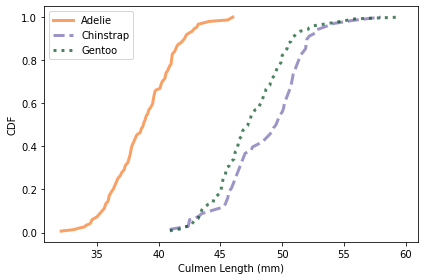

In [9]:
colname = 'Culmen Length (mm)'
plot_cdfs(df, colname)

Qui la distribuzione della lunghezza della pinna.

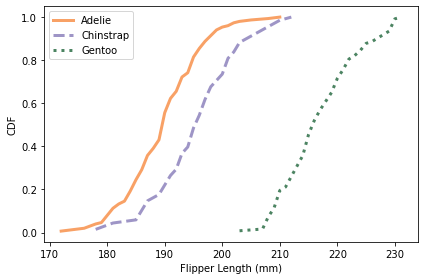

In [10]:
colname = 'Flipper Length (mm)'
plot_cdfs(df, colname)

Qui la distribuzione della profondità del culmen.

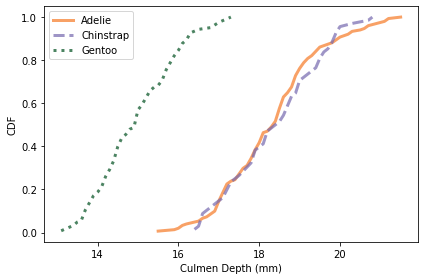

In [11]:
colname = 'Culmen Depth (mm)'
plot_cdfs(df, colname)

Qui la distribuzione della massa.

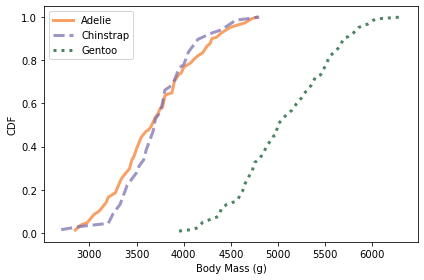

In [12]:
colname = 'Body Mass (g)'
plot_cdfs(df, colname)

La profondità del culmen e la massa distinguone i pinguini Gentoo rispetto alle altre due specie, ma queste caratteristiche possono aggiungere informazioni addizionali, ed è per questo che useremo la lunghezza della pinna e del culmen. 

## Modelli normali
Useremo queste caratteristiche per classificare i pingini. Procederemo nel seguente modo Bayesiano:

1. Definiamo una distribuzione a priori con le tre possibili specie con la probabilità a priori di ogni
2. Calcoliamo la verosomiglinza del dato per ogni ipotetica specie e poi
3. Calcoliamo la probabilità a posteriori per ogni ipotesi.

Per calcolare la verosomiglianza del dato sotto ogni ipotesi, useremo il dato per stimare il parametro di una distribuzione per ogni specie.

La seguente funzione prende un `DataFrame` e un nome di colonna; restituisce un dizionario che mappa per ogni specie con un oggetto `norm`.

`norm` è definito in SciPy; e rappresenta una distribuzione normale con un media e una deviazione standard impostata.

In [13]:
from scipy.stats import norm

def make_norm_map(df, colname, by='Species2'):
    """Make a map from species to norm object."""
    norm_map = {}
    grouped = df.groupby(by)[colname]
    for species, group in grouped:
        mean = group.mean()
        std = group.std()
        norm_map[species] = norm(mean, std)
    return norm_map

Creiamo un dizionario di oggetti `norm` per la lunghezza della pinna:

In [14]:
flipper_map = make_norm_map(df, 'Flipper Length (mm)')
flipper_map.keys()

dict_keys(['Adelie', 'Chinstrap', 'Gentoo'])

Ora supponiamo di misurare un pinguino e di trovare che la pinna sia 193 cm. Quale è la probabilità di questa misura sotto ogni ipotesi?

L'oggetto `norm` ha una proprietà `pdf`, che calcola la densità di probabilità della distribuzione normale. 

In [15]:
data = 193
flipper_map['Adelie'].pdf(data)

0.054732511875530694

Il risultato è una densità di probabilità, dunque non possiamo interpretarlo come una probbailità. Ma è proporzionale alla verosomiglianza del datom dunque possiamo usarla per aggiornare la distribuzione a priori.

Qui come calcolare la verosomiglianza del dato in ogni distribuzione.

In [16]:
hypos = flipper_map.keys()
likelihood = [flipper_map[hypo].pdf(data) for hypo in hypos]
likelihood

[0.054732511875530694, 0.051721356158881626, 5.866045366199098e-05]

Ora siamo pronti per aggiornare il dato.
## L'aggiornamento

Come al solito useremo `Pmf` per rappresentare la distribuzione a priori. Per semplicità, assumeremo che ogni specie è ugualmente probabile.

In [17]:
from distribution import Pmf

prior = Pmf(1/3, hypos)
prior

,probs
Adelie,0.333333
Chinstrap,0.333333
Gentoo,0.333333


Ora possiamo fare l'aggiornamento nel modo usuale.

In [18]:
posterior = prior * likelihood
posterior.normalize()
posterior

,probs
Adelie,0.513860
Chinstrap,0.485589
Gentoo,0.000551


Un pingino con una pinna lunga 193 mm non ha molta probabilità di essere un Gentoo, ma potrebbe essere un Adélie oppure Chinstrap (assumendo che le tre specie siano egualmente distribuite prima della misura).

La seguente funzione incapsula i passi appena fatti. 

In [19]:
def update_penguin(prior, data, norm_map):
    """Update hypothetical species."""
    hypos = prior.qs
    likelihood = [norm_map[hypo].pdf(data) for hypo in hypos]
    posterior = prior * likelihood
    posterior.normalize()
    return posterior

Il valore ritornato è una distribuzione a posteriori.
Qui l'esempio precedente usando `update_penguin`:

In [20]:
posterior1 = update_penguin(prior, 193, flipper_map)
posterior1

,probs
Adelie,0.513860
Chinstrap,0.485589
Gentoo,0.000551


Come abbiamo visto prima, la lunghezza della pinna non riesce a distignuere fortemente tra i pinguini Adélie e Chinstrap.
Ma la lunghezza del culmen *potrebbe* fare questa distinzione, dunque usiamola per fare un secondo passaggio di classifiche.
Primo stimiamo le distribuzioni della lunghezza del culmen per ogni specie: 

In [21]:
culmen_map = make_norm_map(df, 'Culmen Length (mm)')

Ora supponiamo di misurare la lunghezza del culmen e di ottenere  48 mm.
Possiamo usarlo per aggiornare la distribuzione a priori.

In [22]:
posterior2 = update_penguin(prior, 48, culmen_map)
posterior2

,probs
Adelie,0.001557
Chinstrap,0.474658
Gentoo,0.523785


Un pinguino con un culmen lungo 48mm è egualmenti probabile tra Chinstrap o Gentoo.
Usando una feature alla volta, possiamo usare la regola per una specie o altre, ma generalmente non possiamo identificare la specie con una buona confidenza. 
Possiamo fare meglio usando e feature multiple.

## Classificazione Naive Bayes
Per rendere semplice l'aggiornamento multiplo, useremo la seguente funzione, che usa una distribuzione a priori `Pmf`, una sequenza di misure e una corrispondente sequenza di dizionari contenente le stime della distribuzioni.


In [23]:
def update_naive(prior, data_seq, norm_maps):
    """Naive Bayesian classifier
    
    prior: Pmf
    data_seq: sequence of measurements
    norm_maps: sequence of maps from species to distribution
    
    returns: Pmf representing the posterior distribution
    """
    posterior = prior.copy()
    for data, norm_map in zip(data_seq, norm_maps):
        posterior = update_penguin(posterior, data, norm_map)
    return posterior

Esegue una serie di agiornamenti, usando una variabile alla volta e ritorna una distribuzione a posteriori `Pmf`.
Per provarlo, useremo le stesse caratteristiche che abbiamo visto nelle sezioni precedenti: la lunghezza del culmen e la lunghezza della pinna.

In [24]:
colnames = ['Flipper Length (mm)', 'Culmen Length (mm)']
norm_maps = [flipper_map, culmen_map]

Ora supponiamo di avere un pinguino con la pinna lunga 193 mm e un culmen lungo 48 mm.
Qui l'aggiornamento:

In [25]:
data_seq = 193, 48
posterior = update_naive(prior, data_seq, norm_maps)
posterior

,probs
Adelie,0.003455
Chinstrap,0.995299
Gentoo,0.001246


Ora siamo quasi sicuro che sia un Chinstrap.



In [26]:
posterior.max_prob()

'Chinstrap'

Possiamo usare il dataset per classificare ogni pinguino con queste due features.

In [27]:
import numpy as np

df['Classification'] = np.nan

for i, row in df.iterrows():
    data_seq = row[colnames]
    posterior = update_naive(prior, data_seq, norm_maps)
    df.loc[i, 'Classification'] = posterior.max_prob()

Questo loop aggiunge una colonna chiamata `Classification` al `DataFrame`; e contiene la specie con la massima probabilità per ogni pinguino.

Ora vediamo quante previsioni sono corrette.

In [28]:
len(df)

344

In [29]:
valid = df['Classification'].notna()
valid.sum()

342

In [30]:
same = df['Species2'] == df['Classification']
same.sum()

324

Abbiamo 344 pinguini nel dataset, ma due sono senza misure, dunque abbiamo 342 casi validi. Di questi 324 sono classificati correttamente che è circa il 95%. 

In [31]:
same.sum() / valid.sum()

0.9473684210526315

La seguente funzione incapsula questi passi.

In [32]:
def accuracy(df):
    """Compute the accuracy of classification."""
    valid = df['Classification'].notna()
    same = df['Species2'] == df['Classification']
    return same.sum() / valid.sum()

Il classificatore che abbiamo usato in questa sezione è chiamato "naive" perchè ignora la correlazione tra queste feature.
Per vedere perchè è importante, creeremo un classificatore meno naive: prendiamo in considerazione della distribuzione congiunta delle features.

## Distribuzioni congiunte

Partiamo con un grafico dei dati

In [33]:
import matplotlib.pyplot as plt

def scatterplot(df, var1, var2):
    """Make a scatter plot."""
    grouped = df.groupby('Species2')
    for species, group in grouped:
        plt.plot(group[var1], group[var2],
                 label=species, lw=0, alpha=0.3)
    
    decorate(xlabel=var1, ylabel=var2)

Qui il grafico che mette in relazione la lunghezza del culmen e della pinna per tutte e tre le specie.

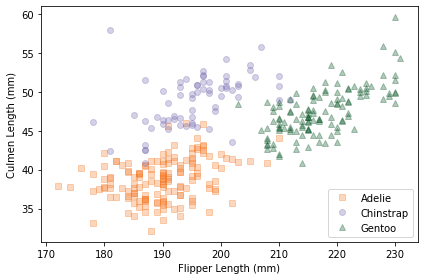

In [34]:
var1 = 'Flipper Length (mm)'
var2 = 'Culmen Length (mm)'
scatterplot(df, var1, var2)

Per ogni specie, la distribuzione congiunta di queste misure creano una forma ovale, almeno approssimativamente.
L'orientamento dell'ovale è lungo la diagonale, che indica l'esistenza di una correlazione tra la lunghezza del culmen e della pinna.

Se ignoriamo queste correlazioni, stiamo assumendo che queste features sono indipendenti. Per vedere che aspetto ha, creeremo una distribuzione di ogni specie assumendo l'indipendenza.

La seguente funzione crea un oggetto discreto `Pmf` che approssima una distribuzione normale.

In [35]:
def make_pmf_norm(dist, sigmas=3, n=101):
    """Make a Pmf approximation to a normal distribution."""
    mean, std = dist.mean(), dist.std()
    low = mean - sigmas * std
    high = mean + sigmas * std
    qs = np.linspace(low, high, n)
    ps = dist.pdf(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

Possiamo usarla, assieme a `make_joint`, per creare una distribuzione congiunta tra la lunghezza del culmen e la lunghezza della pinna per ogni specie.

In [36]:
from utils import make_joint

joint_map = {}
for species in hypos:
    pmf1 = make_pmf_norm(flipper_map[species])
    pmf2 = make_pmf_norm(culmen_map[species])
    joint_map[species] = make_joint(pmf1, pmf2)

Il grafico seguente, compara i grafici dei dati con il contorno della distribuzione congiunta assumento l'indipendenza.

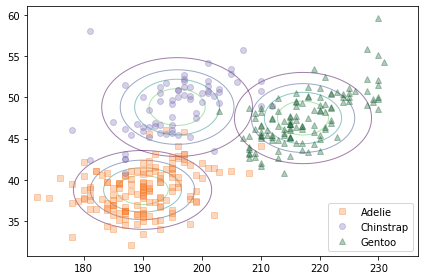

In [37]:
from utils import plot_contour

scatterplot(df, var1, var2)
for species in hypos:
    plot_contour(joint_map[species], alpha=0.5)

I contorni della distribuzione congiunta formano ellissi.
In questo esempio, in quanto le features non sono correlate, le ellissi sono allieneate sugli assi. 
Ma questi non sono ben allineati con i dati.
Possiamo ottenere un modello migliore dal dato e usarlo per calcolare una migliore verosomiglianza, con una distribuzione normale multivariata.

## Distribuzione Normale Multivariata

Come abbiamo visto, la distribuzione normale univariata è caratterizzata dalla sua media e dalla deviazione standard.
Una distribuzione normale multivariata è caratterizzata dalle medie delle sue features e dalla **matrice di covarianza** che contiene le **varianze**, che quantificano la diffusione delle features, e le **covarianze** che quantifica le relazioni tra essi.

Possiamo usare i dati per stimare le medie e la matrice di covarianza per la popolazione dei pinguini.
Prima selezioniamo le colonne che vogliamo.


In [38]:
features = df[[var1, var2]]

e calcoliamo le medie.

In [39]:
mean = features.mean()
mean

Flipper Length (mm)    200.915205
Culmen Length (mm)      43.921930
dtype: float64

Possiamo calcolare la matrice di covarianza:

In [40]:
cov = features.cov()
cov

,Flipper Length (mm),Culmen Length (mm)
Flipper Length (mm),197.731792,50.375765
Culmen Length (mm),50.375765,29.807054


Il risultato è un `DataFrame` con una riga e una colonna per ogni feature. Gli elementi sulla diagonale sono le varianze; gli elementi fuori dalla diagonale sono le covarianze.

Da sole, varianza e covarianza sono difficili da interpretare. Possiamo usarli per calcolare la deviazione standard e i coefficienti di correlazione, che sono più facili da interpretare , ma per i dettagli dei calcolo non sono importanti per ora.

Invece, passeremo la matrice di covarianza con `multivariate_normal`, che è una funzione di SciPy che crea un oggetto che rappresenta un distribuzione multivariata normale.

In [41]:
from scipy.stats import multivariate_normal

multinorm = multivariate_normal(mean, cov)

La seguente funzione crea un oggetto `multivariate_normal` per ogni specie.

In [42]:
def make_multinorm_map(df, colnames):
    """Make a map from each species to a multivariate normal."""
    multinorm_map = {}
    grouped = df.groupby('Species2')
    for species, group in grouped:
        features = group[colnames]
        mean = features.mean()
        cov = features.cov()
        multinorm_map[species] = multivariate_normal(mean, cov)
    return multinorm_map

Qui come creare questa mappa per le prime due features, la lunghezza della pinna e del culmen.

In [43]:
multinorm_map = make_multinorm_map(df, [var1, var2])

## Visualizzare una distribuzione normale multivariata

In questa sezione useremo alcune funzionalità di Numpy per generare un grafico che rappresenta la distribuzione normale multivariata. 

Se questo ti interessa, bene! Nella prossima sezione faremo la classificazione vera e propria, che risulta essere più semplice della visualizzazione.

Partiremo con il creare una mappa per la distribuzione delle features tra i pingioni Adélie.
Qui le distribuzioni univariate per le due features, useremo anche la distribuzione multivariata appena calcolata.



In [44]:
norm1 = flipper_map['Adelie']
norm2 = culmen_map['Adelie']
multinorm = multinorm_map['Adelie']

Creiamo una approssimazione discreta `Pmf` per ogni distribuzione univariata.

In [45]:
pmf1 = make_pmf_norm(norm1)
pmf2 = make_pmf_norm(norm2)

E useremo per create una griglia che contiene tutte le coppie di valori.

In [46]:
X, Y = np.meshgrid(pmf1.qs, pmf2.qs)
X.shape

(101, 101)

Questa griglia è rappresentata da due array: il primo contiene le quantità da  `pmf1` lungo l'asse `x`; la seconda contiene le quantità da `pmf2` lungo l'asse `y`.

In ordine per valutare la distribuzione multivariata di ogni coppia di valori dobbiamo "impilare" i due array.

In [47]:
pos = np.dstack((X, Y))
pos.shape

(101, 101, 2)

IL risultato è un array 3D che possiamo pensare con un array 2D di coppie. Quando passiamo questo array alla funzione `multinorm.pdf`, questa valuta la funzione di densità di probabilità della distribuzione per ogni coppia di valori. 

In [48]:
densities = multinorm.pdf(pos)
densities.shape

(101, 101)

Il risultato è un array di densità di probabilità. Se le mettiamo in un DataFrame e lo normalizziamo il risultato è una approssimazione discreta della distribuzione congiunta delle due features. 

In [49]:
from utils import normalize

joint = pd.DataFrame(densities, columns=pmf1.qs, index=pmf2.qs)
normalize(joint)

15.871343639913832

Qui il risultato.

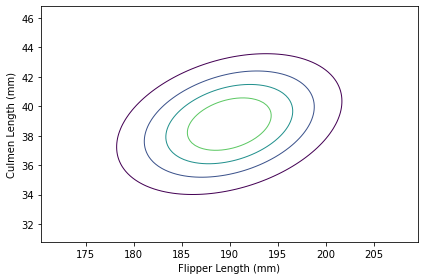

In [50]:
plot_contour(joint)
decorate(xlabel=var1,
         ylabel=var2)

I contorni della distribuzione multivariata sono ancora delle ellissi, ma ora dobbiamo prendere in considerazione la correlazione tra le features, le ellissi non sono allineate con gli assi.

La seguente funzione incapsula i passi che abbiamo appena fatto.

In [51]:
def make_joint(norm1, norm2, multinorm):
    """Make a joint distribution.
    
    norm1: `norm` object representing the distribution of the first feature
    norm2: `norm` object representing the distribution of the second feature
    multinorm: `multivariate_normal` object representing the joint distribution
    """
    pmf1 = make_pmf_norm(norm1)
    pmf2 = make_pmf_norm(norm2)
    X, Y = np.meshgrid(pmf1.qs, pmf2.qs)
    pos = np.dstack((X, Y))
    densities = multinorm.pdf(pos)
    joint = pd.DataFrame(densities, columns=pmf1.qs, index=pmf2.qs)
    return joint

La seguente figura mostra un grafico dei dati della distribuzione multivariata della distribuzione normale per ogni specie. 

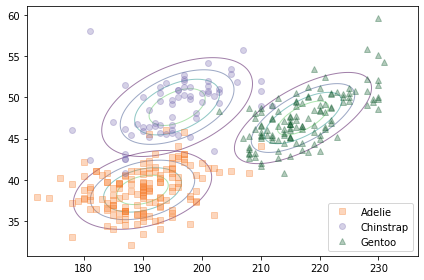

In [52]:
scatterplot(df, var1, var2)

for species in hypos:
    norm1 = flipper_map[species]
    norm2 = culmen_map[species]
    multinorm = multinorm_map[species]
    joint = make_joint(norm1, norm2, multinorm)
    plot_contour(joint, alpha=0.5)

Visto che la distribuzione normale multivariata prende in considerazione la correlazione tra le features, rappresenta un modello migliore per rappresentare il dato. Ci sono meno sovrapposizioni dei contorni delle tre distribuzioni, il che ci suggerisce che avremo una migliore classificazione.


## Un classificatore meno Naive

Nella sezione precedente abbiamo usato `update_penguin` per aggiornare la distribuzione a priori `Pmf` basandosi sui dati osservati e una collezione di oggetti `norm` che modellano la distribuzione delle osservazioni sotto ogni ipotesi.  

In [53]:
def update_penguin(prior, data, norm_map):
    """Update hypothetical species."""
    hypos = prior.qs
    likelihood = [norm_map[hypo].pdf(data) for hypo in hypos]
    posterior = prior * likelihood
    posterior.normalize()
    return posterior

L'ultima volta che abbiamo usato questa funzione, i valori `norm_map` erano oggetti `norm`, ma questo funziona anche se trattiamo oggetti di tipo `multivariate_normal`.  

Possiamo usarlo per classificare un pinguino con una pinna lunga 193cm e un culmen lungo 48cm:

In [54]:
data = 193, 48
update_penguin(prior, data, multinorm_map)

,probs
Adelie,0.002740
Chinstrap,0.997257
Gentoo,0.000003


Un pinguino con queste misure è quasi certamente un Chinstrap.
Ora vediamo se il classificatore funziona meglio del classificatore precedente.

In [55]:
df['Classification'] = np.nan

for i, row in df.iterrows():
    data = row[colnames]
    posterior = update_penguin(prior, data, multinorm_map)
    df.loc[i, 'Classification'] = posterior.idxmax()

Ora calcoliamo l'accuratezza:

In [56]:
accuracy(df)

0.9532163742690059

Queste osservazioni funziona leggermente meglio siamo passati da un valore 94.7% a un 95.3%.

## Riassunto

In questo capitolo, abbiamo implementato un classificatore Bayesiano "naive", nel senso che assume che le features usate per la classificazione sono indipendenti.

Per vederer quanto siano sbagliate queste assunzioni, abbiamo anche implementato un classificatore che usa una distibuzione multivariata normale per modellare la distribuzione congiunta che include anche le dipendenze. 

In questo esempio, il classificatore non naive funziona solo marginalmente meglio.
In un certo senso, questo è deludente. Dopo tutto questo lavoro, vorremmo vedere un sensibile miglioramento.
Ma questa è anche una buona notizia. In generale, un classificatore Baesyano è facile da implementare e richiede pochi calcoli.
Se questo lavora quasi bene come il sistema complesso, potrebbe essere una buona scelta per scopi pratici.

Parlando di casi pratici, potresti aver notato che questo esempio non è molto pratico. Se vuoi identificare le specie dei pinguini, ci sono modi molto più semplici della misura del becco e della pinna.

Ma si sono usi più scentifici di questa classificazione. Uno di questi è relativo al [disformismo sessuale](https://en.wikipedia.org/wiki/Sexual_dimorphism) che rappresenta le differenze tra maschi e femmine negli animali.

In alcune specie, come la rana pescatrice, maschi e femmine sono molto differenti. In altre specie, come il tordo, sono difficili da distinguire.
Vale la pena studiarlo perchè ci da informazioni relative ai comportamenti sociali, la selezione sessuale e l'evoluzione.

Un modo per quantificare il gradi di disformismo sessuale nelle specie è quello di usare un algoritmo di classificazione. Se troviamo che un insieme di features rende possibile la classificazione con una alta accuratezza, avremo una evidenza di alto disformismo. 

